# Causal Inference with Machine Learning

This notebook brings a simple implementation of Causal Inference using the *DoWhy* Python package.

**QUESTION**:<br>
The question we will answer in this notebook is *What is the effect of a job training program on earnings?*.

**DATASET**:<br>
The dataset to be used in the *Lalonde* data, an open source material included with the *EconML* package.



In [1]:
!pip install dowhy --quiet
!pip install ucimlrepo --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.4/398.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.6/192.6 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 39.9 MB/s eta 0:00:00


##Imports

In [12]:
import pandas as pd
import dowhy
from IPython.display import Image, display
from ucimlrepo import fetch_ucirepo

## Load Data

In [39]:
# fetch dataset
online_retail = fetch_ucirepo(id=352)

# data (as pandas dataframes)
df = pd.DataFrame(online_retail.data.features)

# Add column for total expense
df['total'] = df['Quantity'] * df['UnitPrice']

In [40]:
# Taking a subset of the data
df = df.sample(30000)

In [41]:
# What's the average purchase by country
avg_by_country =(
    df
    .groupby('Country')
    .agg({'total':['sum', 'mean']})
    .reset_index()
)

avg_by_country.columns = ['Country', 'total_sum', 'total_mean']

avg_by_country.sort_values(by='total_sum', ascending=False).head(10)

,Country,total_sum,total_mean
33,United Kingdom,426813.17,15.563491
22,Netherlands,14559.39,116.475120
13,Germany,13965.08,25.530311
9,EIRE,13231.06,30.346468
12,France,11683.65,24.040432
0,Australia,8394.53,118.232817
19,Japan,4922.82,189.339231
28,Spain,4348.00,30.619718
30,Switzerland,3452.82,30.024522
3,Belgium,2336.59,21.837290


In [42]:
df.query('Country == "Netherlands"').sample(10)

,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total
347071,LUNCH BAG BLACK SKULL.,100,9/19/2011 11:46,1.45,14646.0,Netherlands,145.00
136972,ROBOT BIRTHDAY CARD,72,3/29/2011 11:04,0.42,14646.0,Netherlands,30.24
408970,DOLLY GIRL LUNCH BOX,256,10/20/2011 12:03,1.65,14646.0,Netherlands,422.40
232772,SET OF 60 I LOVE LONDON CAKE CASES,1,6/20/2011 9:53,0.55,14646.0,Netherlands,0.55
299054,GREEN GOOSE FEATHER CHRISTMAS TREE,6,8/11/2011 16:12,2.95,14646.0,Netherlands,17.70
231352,RING OF ROSES BIRTHDAY CARD,72,6/19/2011 11:08,0.36,14646.0,Netherlands,25.92
492639,LUNCH BAG SUKI DESIGN,100,11/23/2011 10:58,1.45,14646.0,Netherlands,145.00
338413,GIRAFFE WOODEN RULER,144,9/13/2011 11:47,1.65,14646.0,Netherlands,237.60
241954,FOLDING BUTTERFLY MIRROR HOT PINK,96,6/28/2011 8:45,0.72,14646.0,Netherlands,69.12
482665,POSTAGE,-1,11/20/2011 11:39,18.00,12778.0,Netherlands,-18.00


### Prepare the Data

In [43]:
# Using the index as the product ID
df=df.reset_index().rename(columns={'index':'prodID'})

# Transforming the treatment column (Country)
# If United Kingdom: 1, else 0
df['Country'] = df.Country.apply(lambda x: 1 if x=='United Kingdom' else 0)

# View
df.sample(5)

,prodID,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total
7129,272374,CHARLOTTE BAG PINK POLKADOT,4,7/20/2011 16:12,1.63,NaN,1,6.52
18110,388746,PLASTERS IN TIN VINTAGE PAISLEY,1,10/10/2011 15:27,1.65,14529.0,1,1.65
17893,212632,WOODEN CROQUET GARDEN SET,1,6/3/2011 15:31,14.95,15812.0,1,14.95
25601,504283,SET 12 COLOUR PENCILS DOLLY GIRL,1,11/27/2011 13:47,0.65,16005.0,1,0.65
131,406308,FELTCRAFT GIRL NICOLE KIT,4,10/19/2011 10:56,4.95,17043.0,1,19.80


## DoWhy
The basics of the *DoWhy* library are these steps:<br>
1. Create a **CausalModel** object pointing the dataset, the outcome, the Y variable and the graph, if available.
2. Identify the effect using the **model** object created on **Step 1**.
3. Estimate the effect using the **identified estimand** created on **Step 2**.
4. Finally, we can test our estimate with refutation.<br>
  o **Random Common Cause**: Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not. If our assumption was originally correct then the causal estimate shouldn’t change by much.<br>
  o **Placebo Treatment Refuter**: Randomly assigns any covariate as a treatment and re-runs the analysis. If our assumptions were correct then this newly found out estimate should go to 0.<br>
  o **Data Subset Refuter**: Creates subsets of the data(similar to cross-validation) and checks whether the causal estimates vary across subsets. If our assumptions were correct there shouldn’t be much variation.

### Step 1: Creating the Causal Model

In [67]:
# Generating the Causal Graph
causal_graph = """digraph {
Country;
Quantity;
total;
UnitPrice;
prodID;
Z->Country;
Country -> total
Quantity -> Country
Quantity -> total
UnitPrice -> Country
UnitPrice -> Quantity
UnitPrice -> total
prodID -> UnitPrice
}"""

In [74]:
# Step 1: Create the model
model = dowhy.CausalModel(data=df,
                          # graph=causal_graph.replace("\n", " "),
                          common_causes=['Quantity', 'UnitPrice', 'prodID'],
                          treatment="Country",
                          outcome="total")

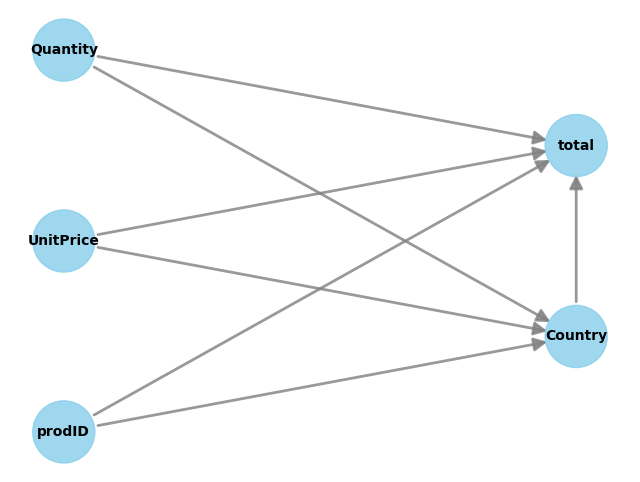

In [75]:
# View the Model
model.view_model()

### Step 2: Identifying the effect

In [70]:
# Identify effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                  
──────────(E[total|UnitPrice,Quantity])
d[Country]                             
Estimand assumption 1, Unconfoundedness: If U→{Country} and U→total then P(total|Country,UnitPrice,Quantity,U) = P(total|Country,UnitPrice,Quantity)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                             -1⎤
 ⎢ d          ⎛ d             ⎞  ⎥
E⎢────(total)⋅⎜────([Country])⎟  ⎥
 ⎣d[Z]        ⎝d[Z]           ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→total then ¬(U →→{Z})
Estimand assumption 2, Exclusion: If we remove {Z}→{Country}, then ¬({Z}→total)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Step 3: Estimate the Average Treatment Effect (ATE)

In [77]:
# Estimate ATE
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_matching",
                                target_units="att")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                  
──────────(E[total|UnitPrice,Quantity])
d[Country]                             
Estimand assumption 1, Unconfoundedness: If U→{Country} and U→total then P(total|Country,UnitPrice,Quantity,U) = P(total|Country,UnitPrice,Quantity)

## Realized estimand
b: total~Country+UnitPrice+Quantity
Target units: att

## Estimate
Mean value: -7.627790985997666



### Step 4: Refute/ Test robustness of the model

In [78]:
# Using the random common cause
refute1_results=model.refute_estimate(identified_estimand,
                                      estimate,
                                      method_name="random_common_cause")

print(refute1_results)

Refute: Add a random common cause
Estimated effect:-7.627790985997666
New effect:-7.627790985997664
p value:1.0



In [79]:
# Using a subset of the data
refute2_results=model.refute_estimate(identified_estimand,
                                      estimate,
                                      method_name="data_subset_refuter")

print(refute2_results)

Refute: Use a subset of data
Estimated effect:-7.627790985997666
New effect:-7.358668391350375
p value:0.8999999999999999



In [80]:
# Placebo Refuter
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute3_results)

Refute: Use a Placebo Treatment
Estimated effect:-7.627790985997666
New effect:0.3125318251396347
p value:0.76

